<a href="https://colab.research.google.com/github/subutayebru/3DCV/blob/main/Advanced_Calibration_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Calibration Workshop!
In this new workshop, you're going to learn about camera calibration in an advanced way. We often see calibration as an easy process: take a few images of a checkerboard, use an OpenCV() function, calibrate!

The reality is often very different, and in this workshop, I want to start calibration with the end in mind. This means when we'll calibrate, **we'll be able to see the 3D Reconstruction, and the impact of calibration on the end result**.

Ready? Let's go!

# Imports

In [ ]:
!pip install open3d==0.19.0
!pip install pythreejs==2.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import open3d as o3d
import pythreejs as p3js

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
!ls

In [ ]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/calib_data.zip && unzip calib_data.zip

# 0. Visualize the folders & images
As you can see, we have **2 charuco folders** (calibration images); one "good" and one "bad". Yes, this means we purposely screwed up the images, took them a bit blurry, incomplete etc... so you can see the difference.<p>
Then, we have a folders with robot picture we took in Taiwan near a content creator's house: **y
/robot**

# 1. Generate a Charuco board
The purpose of camera calibration is to determine the internal parameters (intrinsics) and the relationship between two cameras (extrinsics) in a stereo setup. This helps in correcting distortion, aligning the cameras, and measuring distances in 3D from stereo images.

For a stereo camera like the [ZED 2](https://www.stereolabs.com/en-fr/products/zed-2) (used in this workshop), calibration is crucial to ensure that both the left and right cameras are correctly aligned, which allows for more accurate depth perception and 3D reconstruction.

So what is the first step?

**Yes, the first step is to generate a calibration board.**
<p>
Charuco?
Yes, if you learned calibration, you probably learned via checkerboards. A charuco board isn't too different. It has a calibration pattern made up of a grid of squares (like a traditional chessboard) combined with small ArUco markers inside some squares. ArUco markers are small and easily detectable patterns that help find precise corner locations, even in low-quality or partially occluded images. This makes Charuco boards more reliable for calibration than a regular chessboard.
<p>
> Charuco=Chessboard + Aruco



Now the question is, why generate one? Aren't there any good ones online? Yes, there are, but in calibration, you want to be precise. If your board is printed on a paper, it's different than if it's shown in a TV. And even there, if it's full screen, the board size will be different than if it's not full screen.

**First, we define the charuco board.**<p>
It's done in a few steps:
1. **Step 1**: Define a dictionary of ArUco markers to be used (DICT_4X4_250 means 4x4 markers with up to 250 unique IDs).
2. **Step 2**: Calculate the size of the Charuco board in meters, based on the size of your screen (27-inch display) and the desired size of each square (0.04 meters).
3. **Step 3**: Generate the Charuco board with the number of squares (14x7 grid), and display it on the screen or save it for printing.

> For the data collected for this colab, the board was displayed on a 27-inch screen.


In [ ]:
# Chessboard configuration
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

# Screen dimensions and resolution
screen_diagonal_inches = 27
screen_resolution = (1920, 1080)
screen_aspect_ratio = 16 / 9

# Convert screen diagonal to meters
screen_diagonal_meters = screen_diagonal_inches * 0.0254

# Calculate screen width and height in meters
screen_height_meters = screen_diagonal_meters * (9 / np.sqrt(16**2 + 9**2))
screen_width_meters = screen_diagonal_meters * (16 / np.sqrt(16**2 + 9**2))

# Define the desired size of each square in meters
square_size_meters = 0.04  # example size in meters

# Calculate DPI (dots per meter)
dpm = screen_resolution[0] / screen_width_meters

# Calculate the size of each square in pixels
square_size_pixels = int(square_size_meters * dpm)

# Define the size of the Charuco board
squares_x = 14 # number of squares along the x-axis
squares_y = 7   # number of squares along the y-axis

**Then, we generate and visualize it**.<p>

In [ ]:
# Create the Charuco board
board = cv2.aruco.CharucoBoard((squares_x, squares_y), square_size_pixels / dpm, (square_size_pixels / dpm) * 0.75, aruco_dict)

# Generate the image
image_size = (screen_resolution[0], screen_resolution[1])  # match the screen resolution
image = board.generateImage(image_size, marginSize=0, borderBits=1)

# Display the Charuco board
plt.figure(figsize=(10, 5))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Save the image if needed
cv2.imwrite('output/charuco_board_27inch_14x7.png', image)

In [ ]:
# Get the object points from the Charuco board
charuco_object_points = board.getChessboardCorners()
num_points = len(charuco_object_points)
print(num_points)

# 2. Calibration
We now enter the calibration process, we're going to begin with defining **image points** and **object points**. Image points are in pixels, object points are the real 3D points.

In [ ]:
frameSize = (1920, 1080)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.array(charuco_object_points)  # Shape: (78, 3)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.
objpointsL = [] # 3d point in real world space
objpointsR = [] # 3d point in real world space

idsL = []
cornersL = []
imagesL = []
idsR = []
cornersR = []
imagesR = []

imagesLeft = []
imagesRight = []

parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR

**Description**: This creates a Charuco detector object that is used to detect both ArUco markers and chessboard corners.
* Parameters:
* board: The Charuco board used for calibration.
* detectorParams: The detection parameters configured earlier, such as corner refinement.
* Usage in Code: This detector helps in finding corners and IDs of the ArUco markers on the Charuco board from the calibration images.

$\color{#BB5544}{\text{TODO: Define a Charuco detector using the cv2.aruco.CharucoDetecto() function. Fill in the parameters.}}$


In [ ]:
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

## Step 1 - Find the corners on the image
We are going to run the first step, which is to find corners in the calibration board. The second step will involve matching these from framet to frame. Becuase we'll reuse it often to compare calibration, let's define a function named **find_corners()**

$\color{#BB5544}{\text{TODO: Find the corners for left and right using detector.detectBoard() function. - There is one argument to pass, what is it?}}$


In [ ]:
def find_corners():

  # Convert images to grayscale
  grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
  grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

  frameSize = (grayR.shape[1], grayR.shape[0])

  # Detect the Charuco board in both images
  c_corners_left, c_ids_left, _, _ = #TODO
  retL = len(c_corners_left)
  print("Detected", retL, "corners in left image")

  c_corners_right, c_ids_right, _, _ = #TODO
  retR = len(c_corners_right)
  print("Detected", retR, "corners in right image")

  # Copy images to draw on
  imgL_with_corners = imgL.copy()
  imgR_with_corners = imgR.copy()

  # Draw detected corners and IDs on the left image
  if c_corners_left is not None and c_ids_left is not None:
      cv2.aruco.drawDetectedCornersCharuco(imgL_with_corners, c_corners_left, c_ids_left)


  # Draw detected corners and IDs on the right image
  if c_corners_right is not None and c_ids_right is not None:
      cv2.aruco.drawDetectedCornersCharuco(imgR_with_corners, c_corners_right, c_ids_right)

  # Convert images to RGB for plotting
  imgL_rgb = cv2.cvtColor(imgL_with_corners, cv2.COLOR_BGR2RGB)
  imgR_rgb = cv2.cvtColor(imgR_with_corners, cv2.COLOR_BGR2RGB)

  # Plot images side by side
  plt.figure(figsize=(20, 10))

  plt.subplot(1, 2, 1)
  plt.imshow(imgL_rgb)
  plt.title('Left Image with Detected Corners and IDs')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(imgR_rgb)
  plt.title('Right Image with Detected Corners and IDs')
  plt.axis('off')

  plt.show()

  objpoints.append(objp)

  idsL.append(c_ids_left)
  cornersL.append(c_corners_left)

  idsR.append(c_ids_right)
  cornersR.append(c_corners_right)

Let's run this function for just ONE image.

$\color{#BB5544}{\text{TODO: Pick an image from the dataset and visualize the output?}}$


In [ ]:
# Paths to the left and right images
pathImgL = '/content/calib_data/charuco/left/___'#TODO
pathImgR = '/content/calib_data/charuco/right/'#TODO
imagesLeft.append(pathImgL)
imagesRight.append(pathImgR)

imgL = cv2.imread(pathImgL)
imgR = cv2.imread(pathImgR)

find_corners()

Cool! You can see the patterns in blue! Because we're in Stereo, we did it for the two images, but we could do that for just one camera, the process would be the same!

## Step 2. Match Image Points to Object Points
Again, we'll do this in Stereo Mode; but if you want to do that for one image, you can just remove the left or right functions. We are going to use a visualizer helper function to make a cool visualization.

In [ ]:
def visualize_correspondences(img, imgPoints, objPoints, ids):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Convert image to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a figure with two subplots
    fig = plt.figure(figsize=(20, 10))

    # Plot 2D image points with IDs
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img_rgb)
    for i, pt in enumerate(imgPoints):
        x, y = pt.ravel()
        ax1.scatter(x, y, c='r', marker='o')
        ax1.text(x + 5, y - 5, str(ids[i][0]), color='yellow', fontsize=12)
    ax1.set_title('2D Image Points with IDs')
    ax1.axis('off')

    # Ensure objPoints is a numpy array
    objPoints = np.array(objPoints)

    # Reshape objPoints if necessary
    if objPoints.ndim == 3:
        objPoints = objPoints.reshape(-1, 3)
    elif objPoints.ndim == 2 and objPoints.shape[1] == 1:
        objPoints = np.vstack([pt for pt in objPoints[:, 0]])
    elif objPoints.ndim == 1:
        objPoints = np.vstack(objPoints)

    # Now extract X, Y, Z coordinates
    X = objPoints[:, 0]
    Y = objPoints[:, 1]
    Z = objPoints[:, 2]

    # Plot 3D object points with IDs
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(X, Y, Z, c='b', marker='^')
    for i in range(len(objPoints)):
        ax2.text(X[i], Y[i], Z[i], str(ids[i][0]), color='red', fontsize=10)
    ax2.set_title('3D Object Points with IDs')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')

    plt.show()

$\color{#BB5544}{\text{TODO: Match the objects to the images using the board.matchImagePoints(corners, id) function}}$

In [ ]:
def match_object_images():
  c_corners_left, c_ids_left = cornersL[-1], idsL[-1] # the detected corners and ids for the left image
  c_corners_right, c_ids_right = cornersR[-1], idsR[-1] # the detected corners and ids for the right image

  objPointsL, imgPointsL = #TODO
  imgpointsL.append(imgPointsL)
  objpointsL.append(objPointsL)

  imagesL.append(imgL)

  objPointsR, imgPointsR = #TODO
  imgpointsR.append(imgPointsR)
  objpointsR.append(objPointsR)

  imagesR.append(imgR)

  # Assuming you have imgL, imgPointsL, objPointsL, and c_ids_left
  visualize_correspondences(imgL, imgPointsL, objPointsL, c_ids_left)

In [ ]:
match_object_images()

**Wait, how is that possible?** Well, it's because of all the parameters we defined, remember? We know we have a 27 inch screen, we know the size of each corner, we know every possible real-world value; so this function is actually saying "See this 10 pixel difference? That's 2 cm in reality"!<p>
Realize something: the visualization we ran here is for the left image only. So it's really a mono-calibration so far, done separately on every image.


### Want to test on other images?
Change the filename below, and let's try it again!

In [ ]:
# Paths to the left and right images
pathImgL = '/content/calib_data/charuco/left/ZED_image_left_21.png'
pathImgR = '/content/calib_data/charuco/right/ZED_image_right_21.png'
imagesLeft.append(pathImgL)
imagesRight.append(pathImgR)

imgL = cv2.imread(pathImgL)
imgR = cv2.imread(pathImgR)

find_corners() #step 1
match_object_images() #step2

## Step 3 — Calibrate!
We are now ready for the calibration, which means the generation of the camera's **intrinsic** AND **extrinsic** parameters. Because we have the chance to have two images, we can also do the extrinsic parameters between Image Left and Right later. For now, let's focus on the calibration of each of the cameras...

###**Let's begin with the intrinsics**

$\color{#BB5544}{\text{TODO: Use the cv2.CalibrateCamera(object, images, framezsize, None,None) function}}$

In [ ]:
def calibrate():
  print("\nCalibrating left cam")
  retL, cameraMatrixL, distL, rvecsL, tvecsL = #TODO
  heightL, widthL, channelsL = imgL.shape
  newCameraMatrixL, roi_L = cv2.getOptimalNewCameraMatrix(cameraMatrixL, distL, (widthL, heightL), 1, (widthL, heightL))
  print("Image size = ", frameSize)
  print("Reprojection error = ", retL)
  print("Intrinsic parameter K = ", cameraMatrixL)
  print("Distortion parameters d = ", distL)

  print("\nCalibrating right cam")
  retR, cameraMatrixR, distR, rvecsR, tvecsR = #T0DO
  heightR, widthR, channelsR = imgR.shape
  newCameraMatrixR, roi_R = cv2.getOptimalNewCameraMatrix(cameraMatrixR, distR, (widthR, heightR), 1, (widthR, heightR))
  print("Image size = ", frameSize)
  print("Reprojection error = ", retR)
  print("Intrinsic parameter K = ", cameraMatrixR)
  print("Distortion parameters d = ", distR)

  return newCameraMatrixL, distL, rvecsL, tvecsL, newCameraMatrixR, distR, rvecsR, tvecsR

**About the function:**
We are sending the left image points (2D) and the object points (3D) to the function. We then do the same for right. The function is using this on all corners of the image to find the parameters. <p>

Then, it returns:
* **retL / retR**: The reprojection error, a measure of how well the points project back into the image.
* **cameraMatrixL / cameraMatrixR**: The intrinsic camera matrix for the left and right cameras, respectively.
* **distL / distR**: The distortion coefficients for the left and right cameras.

In [ ]:
cameraMatrixL, distL, rvecsL, tvecsL, cameraMatrixR, distR, rvecsR, tvecsR = calibrate()

**So What Did the Calibration Give us? 3 things:**<p>

1. **The Intrinsic Parameters**, encapsulated in a matrix **K**. It is of shape 3x3 and encapsulates the values of the camera. Skew (s, usually 0 unless axis are not perpendicular), Offset (cx, cy), Focal Length (fx, fy). Its general form is:
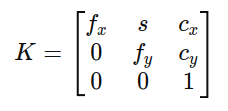



2. **The Distortion Coefficients** (distL, distR); which model the lens distortion of a camera. They are crucial for correcting images to ensure accurate measurements and representations. A few types of distortions are possible, **radial** (causing straight lines to appear curved, resulting in barrel or pincushion distortion), **barrel** (causes images to bulge outward at the center, making straight lines appear to curve inward toward the center, resembling the shape of a barrel), **pincushion** (causes images to pinch inward at the center, making straight lines appear to curve outward away from the center, resembling the shape of a pincushion), or even **tengential** (which occurs when the lens and image sensor are not perfectly parallel, causing asymmetrical distortion). The distortion coefficients (distL or distR) returned by the camera calibration are:[k1, k2, p1, p2, k3]

3. **The Reprojection Error**:
The reprojection error is a measure of how the calibration performed. This happens at tehe end of calibration, to validate our parameters, we use them to project the 3D points back to the image, and calculate the difference between the observed and projected 2D points. Typically:
* A Low Reprojection Error Indicates that the estimated camera parameters accurately model the imaging process. The projected points closely match the observed points.
* A High Reprojection Error suggests inaccuracies in calibration. Possible causes include poor feature detection, insufficient calibration images, or unmodeled lens distortions.

#### **What about t and R? Aren't they given?**
Yes, if you notice correctly, the function is like this:
`retL, cameraMatrixL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpointsL, imgpointsL, frameSize, None, None) # calibrate left`
Which gives us rvecsL and rvecsL. Let's print these:



In [ ]:
print(rvecsL) #rotation vectors

In [ ]:
print(tvecsL) #translation vectors

These represent each camera's pose (rotation and translation) **relative** to the charuco board. If you compute it for 20 images, you're gonna have 20 different parameters. We don't want this: we want only ONE extrinsic parameter for the camera, representing the camera's relationship with the world. We want **absolute**.

### **Now, let's see the Extrinsic parameters**
In theory, the original calibration function could immediately return the extrinsics. For the sake of this project, we'll use the function **solvePnP** from OpenCV: `cv2.solvePnP(objPoints, imgPoints, K, d)` to  find the extrinsics.

**What does it do?** <p>
This function estimates the **pose** (position and orientation) of a calibrated camera with respect to a known object or scene. It computes the **rotation and translation vectors** (`rvec`, `tvec`) that map 3D object points to their corresponding 2D image points, given the camera's intrinsic parameters and distortion coefficients.


Parameters:
- **objPoints** and **imgPoints**
- **K** (intrinsics)  
- **d** (distortion coefficients)

Return Values:
- **retval**: Boolean flag indicating success (`True`) or failure (`False`) of the pose estimation.
- **rvec, tvec**: Output rotation and translation vectors.
  

**In order to make it REALLY COOL**, we are going to define a few function to visualize the cameras in 3D and their poses.

For this, we need to obtain the pose in the camera-to-world.
We can use this code for that:
```python
R_w2c = cv2.Rodrigues(p_rvec)[0]  # Convert the rotation vector to a rotation matrix (world-to-camera)
R_c2w = np.linalg.inv(R_w2c)  # Invert the rotation matrix to get camera-to-world rotation
t_c2w = -R_c2w.dot(p_tvec).reshape((1,3))  # Calculate camera-to-world translation
```
The result, R_c2w and t_c2w, can be used to plot the camera pose in the world coordinate system.
**

In [ ]:
def plotCamera(ax, R, t, *, color=None, scale=1, width=2, height=1.5, focal_length=3):

    t = t.reshape((3, 1))

    w = width
    h = height
    f = focal_length

    # focus, br, tr, tl, bl, triangle
    ps_c = np.array(([0,0,0], [w/2,h/2,f], [w/2,-h/2,f], [-w/2,-h/2,f], [-w/2,h/2,f], [0,-h/2-h/4,f]))
    ps_w = (scale * R @ ps_c.T + t).T

    L01 = np.array([ps_w[0], ps_w[1]])
    L02 = np.array([ps_w[0], ps_w[2]])
    L03 = np.array([ps_w[0], ps_w[3]])
    L04 = np.array([ps_w[0], ps_w[4]])
    L1234 = np.array([ps_w[1], ps_w[2], ps_w[3], ps_w[4], ps_w[1]])
    L253 = np.array([ps_w[2], ps_w[5], ps_w[3]])

    p = ax.plot(L01[:,0], L01[:,1], L01[:,2], "-", color=color)
    if color is None:
        color = p[-1].get_color()
    ax.plot(L02[:,0], L02[:,1], L02[:,2], "-", color=color)
    ax.plot(L03[:,0], L03[:,1], L03[:,2], "-", color=color)
    ax.plot(L04[:,0], L04[:,1], L04[:,2], "-", color=color)
    ax.plot(L1234[:,0], L1234[:,1], L1234[:,2], "-", color=color)
    ax.plot(L253[:,0], L253[:,1], L253[:,2], "-", color=color)

Next the high level function that computes the extrinsics:

In [ ]:
def plot_camera_poses(imgs_all_corners, K, d, all_obj_pts, all_img_pts, all_ids, all_corners):
    # plotCamera() config
    plot_mode   = 1    # 0: fixed camera / moving chessboard,  1: fixed chessboard, moving camera
    plot_range  = 0.5 # target volume [-plot_range:plot_range]
    camera_size = 0.02  # size of the camera in plot

    for i, objPoints, imgPoints, c_ids, c_corners in zip(imgs_all_corners, all_obj_pts, all_img_pts, all_ids, all_corners):
        frame = cv2.imread(i)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        ret, p_rvec, p_tvec = cv2.solvePnP(objPoints, imgPoints, K, d)

        if p_rvec is None or p_tvec is None:
            continue
        if np.isnan(p_rvec).any() or np.isnan(p_tvec).any():
            continue
        cv2.drawFrameAxes(frame,
                        K,
                        d,
                        p_rvec,
                        p_tvec,
                        0.1)
        cv2.aruco.drawDetectedCornersCharuco(frame, c_corners, c_ids)

        r_matrix = cv2.Rodrigues(p_rvec)[0]
        print('Translation : {0}'.format(p_tvec))
        print('Rotation Vector : {0}'.format(p_rvec))
        print('Rotation Matrix : {0}'.format(r_matrix))
        print('Distance from camera: {0} m'.format(np.linalg.norm(p_tvec)))

        # show sample image
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.figure()
        plt.imshow(frame_rgb)
        plt.show()

        # Plot
        fig_ex = plt.figure()

        ax_ex = Axes3D(fig_ex, auto_add_to_figure=False)
        ax_ex.view_init(elev=None, azim=40, vertical_axis='y')
        fig_ex.add_axes(ax_ex)

        ax_ex.set_xlim(-plot_range, plot_range)
        ax_ex.set_ylim(-plot_range, plot_range)
        ax_ex.set_zlim(-plot_range, plot_range)

        R_w2c = cv2.Rodrigues(p_rvec)[0]
        R_c2w = np.linalg.inv(R_w2c)
        t_c2w = -R_c2w.dot(p_tvec).reshape((1,3))

        plotCamera(ax_ex, R_c2w, t_c2w, color="b", scale=camera_size)
        print(objPoints.shape)
        ax_ex.plot(objPoints[:,0,0], objPoints[:,0,1], objPoints[:,0,2], ".")
        plt.show()

Now, let's call it:

In [ ]:
plot_camera_poses(imagesLeft, cameraMatrixL, distL, objpointsL, imgpointsL, idsL, cornersL)

### Step 4 — Visualize Distortions & Corrections
The Zed 2 camera has very little distortion, so you will have to look very carefully no notice the difference between the distorted and undistorted images.Let's take a look anyway.

In [ ]:
print("Computing undistortion maps...")
undistort_map1 = cv2.initUndistortRectifyMap(cameraMatrixL,
                                            distL,
                                            np.eye(3),
                                            cameraMatrixL,
                                            frameSize,
                                            cv2.CV_32F)

# Load a stereo image pair
img_fn = '/content/calib_data/charuco/left/ZED_image_left_21.png'
img1_left_raw = cv2.imread(img_fn)

# show sample image
frame_rgb = cv2.cvtColor(img1_left_raw, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(frame_rgb)
plt.show()

# Undistort images - undistortion example
print("Undistorting image")
img1_left_undist = cv2.remap(img1_left_raw, *undistort_map1, cv2.INTER_LANCZOS4)

# show sample image
frame_rgb = cv2.cvtColor(img1_left_undist, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(frame_rgb)
plt.show()

### Step 5 — Stereo Calibration & Main Function
Okay, we now have a way to calibrate, should we build a "main" function we can use that encapsulates everything? You'll see that we can do it, and we can also run Stereo Calibration!

#### How does Stereo Calibration work?
The principle is quite simple: you're going to use both of the parameter you found and try to compute parameter from camera Left to camera Right. The goal here is to find a rotation and translation matrix that tell you which movement you need to go from Camera Left to Right.<p>
The function used is `cv2.stereoCalibrate()`


$\color{#BB5544}{\text{TODO: Repeat the process with the 3 key functions to run the calibration.}}$

In [ ]:
def calibration(strict = True):
  '''Termination criteria
  Description: These are termination criteria used in iterative algorithms to define when to stop.
  Parameters:
  cv2.TERM_CRITERIA_EPS: Stops when the change in parameter values is less than the specified threshold.
  cv2.TERM_CRITERIA_MAX_ITER: Stops after a specified maximum number of iterations.
  30: The maximum number of iterations for the optimization process.
  0.001: The minimum accuracy to stop the optimization process.
  Usage in Code: This termination criterion is used for subpixel corner detection, controlling the precision and iteration limits.
  '''
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
  print(charuco_object_points.shape)

  # Assuming you have the object points from the Charuco board
  objp = np.array(charuco_object_points)  # Shape: (78, 3)

  # Arrays to store object points and image points from all the images.
  objpoints = [] # 3d point in real world space
  imgpointsL = [] # 2d points in image plane.
  imgpointsR = [] # 2d points in image plane.
  objpointsL = [] # 3d point in real world space
  objpointsR = [] # 3d point in real world space

  idsL = []
  cornersL = []
  imagesL = []
  idsR = []
  cornersR = []
  imagesR = []


  imagesLeft = sorted(glob(CALIBRATION_IMAGES_PATH_LEFT))
  imagesRight = sorted(glob(CALIBRATION_IMAGES_PATH_RIGHT))

  parameters =  cv2.aruco.DetectorParameters()
  parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
  '''
  Description: This creates a Charuco detector object that is used to detect both ArUco markers and chessboard corners.
  Parameters:
  board: The Charuco board used for calibration.
  detectorParams: The detection parameters configured earlier, such as corner refinement.
  Usage in Code: This detector helps in finding corners and IDs of the ArUco markers on the Charuco board from the calibration images.
  '''
  detector = #TODO: Initialize a Detector

  # count = 0
  for imgLeft, imgRight in zip(imagesLeft, imagesRight):

      print(imgLeft, imgRight)
      imgL = cv2.imread(imgLeft)
      imgR = cv2.imread(imgRight)
      grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
      grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

      c_corners_left, c_ids_left, corners, ids = #TODO: Detect the board
      if c_corners_left is None:
          continue
      retL = len(c_corners_left)

      c_corners_right, c_ids_right, corners, ids = #TODO: Detect the Board
      if c_corners_right is None:
          continue
      retR = len(c_corners_right)

      frameSize = (grayR.shape[1], grayR.shape[0])


      if (not strict and retL >= 40 and retR >= 40 and retL == retR)  or (retL == retR and retR == 78):
          print("Found", retL, retR,  "corners")
          objpoints.append(objp)

          '''
          Description: Matches the detected 2D points (corners) from the Charuco board in the image with the corresponding 3D points (known positions) on the Charuco board.
          Parameters:
          c_corners_left / c_corners_right:
          The detected 2D coordinates (corners) of the Charuco board in the left and right camera images, respectively.
          These points are detected by the Charuco board detector and represent the positions of the Charuco corners in the image.
          c_ids_left / c_ids_right:
          The IDs of the detected ArUco markers associated with the corners.
          These IDs help identify the specific markers detected on the Charuco board, allowing for accurate matching between the detected points and the known 3D positions on the board.
          Return Values:
          objPointsL / objPointsR:
          The 3D object points (real-world coordinates) corresponding to the detected corners in the left and right camera images, respectively.
          These points are known, fixed positions on the Charuco board in real-world units (like meters).
          imgPointsL / imgPointsR:
          The 2D image points (detected corner coordinates) from the left and right camera images, respectively.
          These points are the pixel locations in the images where the Charuco corners were detected, which are mapped to the corresponding 3D object points.
          Usage in Code: This function links the 2D points detected in the left and right images with their corresponding 3D points on the Charuco board.
          These matched points (2D image points and 3D object points) are essential for the camera calibration process, as they provide the data needed to
          compute the camera's intrinsic parameters and the stereo camera's relative position and orientation.
          '''
          objPointsL, imgPointsL = #TODO: Match Image-Object Points
          imgpointsL.append(imgPointsL)
          objpointsL.append(objPointsL)
          idsL.append(c_ids_left)
          cornersL.append(c_corners_left)
          imagesL.append(imgLeft)

          objPointsR, imgPointsR = #TODO: Match Image-Object Points
          imgpointsR.append(imgPointsR)
          objpointsR.append(objPointsR)
          idsR.append(c_ids_right)
          cornersR.append(c_corners_right)
          imagesR.append(imgRight)

          # count += 1
          # if count > 5:
          #   break

  ############# CALIBRATION #######################################################
  '''
  Description: Calibrates the camera by estimating its intrinsic parameters and distortion coefficients.
  Parameters:
  objpointsL / objpointsR: List of 3D object points in the real world for the left and right cameras.
  imgpointsL / imgpointsR: List of 2D image points for the left and right cameras, detected in the images.
  frameSize: The size of the image in pixels.
  None: No initial intrinsic parameters are passed.
  Return Values:
  retL / retR: The reprojection error, a measure of how well the points project back into the image.
  cameraMatrixL / cameraMatrixR: The intrinsic camera matrix for the left and right cameras, respectively.
  distL / distR: The distortion coefficients for the left and right cameras.
  Usage in Code: Calibrates each camera separately, estimating intrinsic parameters such as focal length and optical center, and correcting for lens distortion.
  '''
  print("\nCalibrating left cam")
  retL, cameraMatrixL, distL, rvecsL, tvecsL = #TODO: Calibrate the Camera
  heightL, widthL, channelsL = imgL.shape
  newCameraMatrixL, roi_L = cv2.getOptimalNewCameraMatrix(cameraMatrixL, distL, (widthL, heightL), 1, (widthL, heightL))
  print("Image size = ", frameSize)
  print("Reprojection error = ", retL)
  print("Intrinsic parameter K = ", cameraMatrixL)
  print("Distortion parameters d = ", distL)

  print("\nCalibrating right cam")
  retR, cameraMatrixR, distR, rvecsR, tvecsR = #TODO: Calibrate the Camera
  heightR, widthR, channelsR = imgR.shape
  newCameraMatrixR, roi_R = cv2.getOptimalNewCameraMatrix(cameraMatrixR, distR, (widthR, heightR), 1, (widthR, heightR))
  print("Image size = ", frameSize)
  print("Reprojection error = ", retR)
  print("Intrinsic parameter K = ", cameraMatrixR)
  print("Distortion parameters d = ", distR)

  ######### Stereo Vision Calibration #############################################
  flags = 0
  flags = cv2.CALIB_FIX_INTRINSIC

  criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

  '''
  Description: Performs stereo calibration to determine the relationship between two cameras, including extrinsic parameters like rotation (R) and translation (T).
  Parameters:
  objpointsL: 3D object points from the left camera.
  imgpointsL: 2D image points from the left camera.
  imgpointsR: 2D image points from the right camera.
  cameraMatrixL / cameraMatrixR: The intrinsic matrices for the left and right cameras.
  distL / distR: Distortion coefficients for the left and right cameras.
  frameSize: The image size.
  criteria_stereo: Termination criteria for the optimization process.
  flags: This specifies how the stereo calibration should be done. In this case, cv2.CALIB_FIX_INTRINSIC is used to keep the intrinsic parameters fixed during stereo calibration.
  Return Values:
  retStereo: The reprojection error for the stereo pair.
  rot: The rotation matrix describing the orientation difference between the two cameras.
  trans: The translation vector between the two cameras.
  essentialMatrix: Describes the epipolar geometry between the cameras.
  fundamentalMatrix: Describes the relationship between corresponding points in both images.
  Usage in Code: This function calibrates the stereo setup, providing the extrinsic parameters (rotation and translation) that describe the spatial relationship between the two cameras.
  '''
  print("\nCalibrating stereo")
  retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, rot, trans, essentialMatrix, fundamentalMatrix = #TODO: Calibrate the Camera in Stereo Mode
  # ret_stereo, K_left_stereo, d_left_stereo, K_right_stereo, d_right_streo, R, T, E, F
  print('\nstereo vision done')
  print("Reprojection error = ", retStereo)
  print("INTRINSIC PARAMETERS:")
  print(" LEFT CAMERA:")
  print(" Intrinsic parameter K = ", newCameraMatrixL)
  print(" Distortion parameters d = ", distL)
  print(" RIGHT CAMERA:")
  print(" Intrinsic parameter K = ", newCameraMatrixR)
  print(" Distortion parameters d = ", distR)
  print("EXTRINSIC PARAMETERS - LEFT TO RIGHT:")
  print(" Rotation matrix = ", rot)
  print(" Translation vector = ", trans)
  print("EPIPOLAR GEOMETRY")
  print(" Essential matrix = ", essentialMatrix)
  print(" Fundamental matrix = ", fundamentalMatrix)

  return frameSize, imagesL, objpointsL, imgpointsL, idsL, cornersL, newCameraMatrixL, distL, rvecsL, tvecsL, imagesR, objpointsR, imgpointsR, idsR, cornersR, newCameraMatrixR, distR, rvecsR, tvecsR, rot, trans, fundamentalMatrix, essentialMatrix


### Let's run a calibration with the good images!

In [ ]:
# Paths to the captured frames (should be in synch) (stereoLeft and stereoRight)
CALIBRATION_IMAGES_PATH_LEFT = '/content/calib_data/charuco/left/*.png'
CALIBRATION_IMAGES_PATH_RIGHT = '/content/calib_data/charuco/right/*.png'

frameSize, imagesL, objpointsL, imgpointsL, idsL, cornersL, cameraMatrixL, distL, rvecsL, tvecsL, imagesR, objpointsR, imgpointsR, idsR, cornersR, cameraMatrixR, distR, rvecsR, tvecsR, rot, trans, fundamentalMatrix, essentialMatrix = calibration(strict = False)

## Step 4 — Show the Camera Poses
This step is really for fun, but it also looks really good.
### Individual Poses

In [ ]:
numImgs = len(imagesL)
plot_camera_poses(imagesL[:numImgs], cameraMatrixL[:numImgs], distL[:numImgs], objpointsL[:numImgs], imgpointsL[:numImgs], idsL[:numImgs], cornersL[:numImgs])

### All Poses

In [ ]:
def plot_camera_all_poses(objPoints, rvec, tvec):

    # plotCamera() config
    plot_range  = 0.5
    camera_size = 0.02

    fig_in = plt.figure()
    ax_in = Axes3D(fig_in, auto_add_to_figure=False)
    fig_in.add_axes(ax_in)

    ax_in.set_xlim(-plot_range, plot_range)
    ax_in.set_ylim(-plot_range, plot_range)
    ax_in.set_zlim(-plot_range, plot_range)
    ax_in.view_init(elev=None, azim=40, vertical_axis='y')

    for i_ex in range(len(rvec)):
        R_c2w = np.linalg.inv(cv2.Rodrigues(rvec[i_ex])[0])
        t_c2w = -R_c2w.dot(tvec[i_ex]).reshape((1,3))

        plotCamera(ax_in, R_c2w, t_c2w, color="b", scale=camera_size)

    ax_in.plot(objPoints[:,0,0], objPoints[:,0,1], objPoints[:,0,2], ".")


In [ ]:
plot_camera_all_poses(objpointsL[0], rvecsL, tvecsL)

This is cool, admit it. We are done with Part 2 on calibration!

<p>

What now?

We are officially done with Module 1, and we are going to jump to Module 2! But before this, I would like to take 3 minutes and have you run the next cells. Even if you don't understand them yet (as this will be the point of Module 2), I'd like you to see the impact of a good and a bad calibration on the 3D Reconstruction.<p>

* **ASSIGNMENT 1**: Naively run the next cells to visualize the output of a good versus a bad calibration
* **ASSIGNMENT 2**: Visit Module 2 and learn about the concepts of epipolar geometry, depth maps, and disparity.
* **ASSIGNMENT 3**: Go back to this part and run the cells, this time understanding them.

# 3. Epipolar Geometry & 3D Reconstruction

Epipolar geometry describes the geometric relationship between two views of the same scene from different perspectives (e.g., from a stereo camera setup). It is fundamental for understanding how corresponding points in one image (from the left camera) relate to points in the other image (from the right camera).

In stereo vision, corresponding points in the left and right images must lie on epipolar lines. The goal of epipolar geometry is to find these corresponding points and epipolar lines, which helps in tasks like depth estimation and 3D reconstruction.

Process:
- We detect keypoints (or corners) in both left and right images using one of two methods.
- We use these keypoints to compute epipolar lines in the other image.
- We draw the corresponding points in one image and the computed epipolar lines in the other image to visualize the relationship between them.

Notes:
- Rectification: The key part of stereo vision preprocessing, ensuring that corresponding points lie on the same horizontal line in both images.
- Epipolar Geometry: Visualized to show how points in one image correspond to lines in the other image.
- Calibration Data: The fundamental matrix and rectification transforms (R1, R2, P1, P2) come from the stereo calibration process and are crucial for accurate epipolar line computation.

In [ ]:
def draw_epipolar_lines(img1, img2, lines1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c, _ = img1.shape
    for r, pt2 in zip(lines1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 10)
        img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 15, color, -1)
    return img1, img2


def show_epipolar_geometry(pathImgL, pathImgR, uml = None, umr = None, method = 1):

  imgL = cv2.imread(pathImgL)
  imgR = cv2.imread(pathImgR)

  # If defined, we will undistort the images
  if uml and umr:
    # Undistort images
    print("Undistorting image")

    '''
    Description: This function applies the undistortion and rectification maps to the original images,
    effectively correcting lens distortion and aligning the images horizontally.
    Parameters:
    imgL / imgR: The original left and right images.
    undistort_map_left / undistort_map_right: The undistortion and rectification maps computed earlier.
    cv2.INTER_LANCZOS4: An interpolation method used for remapping, known for its high-quality results.
    Return Values:
    imgUndistL / imgUndistR: The rectified (undistorted) images.
    '''
    imgUndistL = cv2.remap(imgL, *uml, cv2.INTER_LANCZOS4)
    imgUndistR = cv2.remap(imgR, *umr, cv2.INTER_LANCZOS4)
  else:
    imgUndistL = imgL
    imgUndistR = imgR

  # Method 1: Using SIFT to get keypoints
  if method == 1:
    '''
    Description: Creates a SIFT (Scale-Invariant Feature Transform) detector used to detect keypoints and compute descriptors for each keypoint.
    Usage in Code: Used to detect feature points (keypoints) in the left and right images for epipolar geometry calculations.
    '''
    # Find the keypoints and descriptors with SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(imgUndistL, None)
    kp2, des2 = sift.detectAndCompute(imgUndistR, None)

    '''
    Description: Uses the FLANN (Fast Library for Approximate Nearest Neighbors) algorithm to match feature descriptors between the two images.
    Parameters:
    index_params: Specifies the algorithm and number of trees to be used for matching.
    search_params: Specifies the number of times to check each candidate match.
    Return Values:
    Matches between the keypoints in the left and right images.
    Usage in Code: Matches keypoints from the left and right images based on their feature descriptors.
    '''
    # Use FLANN-based matcher to find matches
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    ptsL = []
    ptsR = []

    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)

    # Sort the matches by distance (quality of the match)
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    # Choose the top n matches
    n = 10  # Set this to the number of top matches you want
    ptsL = np.int32([kp1[m.queryIdx].pt for m in good_matches[:n]])
    ptsR = np.int32([kp2[m.trainIdx].pt for m in good_matches[:n]])

  # Method 2: Using Good Features to Track to get keypoints
  else:
    '''
    Description: Detects good features (keypoints) in an image based on the Harris corner detection algorithm.
    Parameters:
    Grayscale image: The input image in grayscale.
    maxCorners: Maximum number of keypoints to detect.
    qualityLevel: Minimum accepted quality of corners.
    minDistance: Minimum distance between detected keypoints.
    Return Values:
    The coordinates of the detected keypoints.
    Usage in Code: Used as an alternative method for detecting keypoints if SIFT is not used.
    '''
    # Detect keypoints in the rectified left image
    ptsL = cv2.goodFeaturesToTrack(cv2.cvtColor(imgUndistL, cv2.COLOR_BGR2GRAY), maxCorners=10, qualityLevel=0.01, minDistance=100)
    ptsL = np.int32(ptsL).reshape(-1, 2)

    # Detect keypoints in the rectified right image
    ptsR = cv2.goodFeaturesToTrack(cv2.cvtColor(imgUndistR, cv2.COLOR_BGR2GRAY), maxCorners=10, qualityLevel=0.01, minDistance=100)
    ptsR = np.int32(ptsR).reshape(-1, 2)

  '''
  Description: Computes the epipolar lines for a set of points in one image, mapping them to the corresponding epipolar lines in the other
  image based on the fundamental matrix.
  Parameters:
  ptsL / ptsR: Points from the left or right image.
  1 or 2: Specifies whether the points are from the left (1) or right (2) image.
  fundamentalMatrix: The fundamental matrix, which describes the epipolar geometry between the two cameras.
  Return Values:
  linesR / linesL: The epipolar lines corresponding to the points in the opposite image.
  Usage in Code: Computes the epipolar lines based on the matched points from the stereo images.
  '''
  # Compute epilines corresponding to points in the left image, map to the right image
  linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 1, fundamentalMatrix)
  linesR = linesR.reshape(-1, 3)

  '''
  Description: Draws epipolar lines on one image and the corresponding points on another image.
  These lines represent the possible locations of corresponding points in stereo images.
  Parameters:
  img1: Image on which to draw the epipolar lines.
  img2: Image on which to draw the corresponding points.
  lines1: Epipolar lines computed from the fundamental matrix.
  pts2: Points from the other image corresponding to the epipolar lines.
  Return Values:
  img1: The first image with epipolar lines drawn.
  img2: The second image with corresponding points marked.
  Usage in Code: This function is called to visualize the epipolar lines and corresponding points after computing them from the fundamental matrix.
  '''
  # Draw the epipolar lines on the right image and the points on the left image
  imgR_with_lines, imgL_with_points = draw_epipolar_lines(imgUndistR.copy(), imgUndistL.copy(), linesR, ptsL)
  plt.figure(figsize=(20, 10))

  # Plot the images with epipolar lines
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(imgL_with_points, cv2.COLOR_BGR2RGB))
  plt.title('Points in left image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(imgR_with_lines, cv2.COLOR_BGR2RGB))
  plt.title('Corresponding Epipolar Lines in right image')
  plt.axis('off')

  # Compute epilines corresponding to points in the right image, map to the left image
  linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1, 1, 2), 2, fundamentalMatrix)
  linesL = linesL.reshape(-1, 3)

  # Draw the epipolar lines on the left image and the points on the right image
  imgL_with_lines, imgR_with_points = draw_epipolar_lines(imgUndistL.copy(), imgUndistR.copy(), linesL, ptsR)
  plt.figure(figsize=(20, 10))

  # Plot the images with epipolar lines
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(imgR_with_points, cv2.COLOR_BGR2RGB))
  plt.title('Points in right image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(imgL_with_lines, cv2.COLOR_BGR2RGB))
  plt.title('Corresponding Epipolar Lines in left image')
  plt.axis('off')


  plt.show()


In [ ]:
# Stereo Rectification
print("Computing undistortion and rectifications maps...")
'''
Description: Computes the rectification transforms (R1, R2) and projection matrices (P1, P2) for both left and right cameras,
given the stereo camera parameters. This function is key for aligning the images horizontally.
Parameters:
cameraMatrixL / cameraMatrixR: Intrinsic matrices of the left and right cameras, respectively.
distL / distR: Distortion coefficients for the left and right cameras.
frameSize: Size of the images.
rot: Rotation matrix describing the orientation difference between the cameras.
trans: Translation vector describing the relative position between the cameras.
Return Values:
R1 / R2: Rotation matrices for the left and right cameras, respectively.
P1 / P2: New projection matrices for the left and right cameras, respectively.
Q: The disparity-to-depth mapping matrix (used for depth map generation).
roiL / roiR: The regions of interest for the rectified left and right images.
'''
R1, R2, P1, P2, Q, roiL, roiR = cv2.stereoRectify(cameraMatrixL, distL, cameraMatrixR, distR, frameSize, rot, trans)

#  Undistortion and Rectification Maps
'''
Description: This function computes the undistortion and rectification transformation maps, which are later used to remap the images
for rectification and undistortion.
Parameters:
cameraMatrixL / cameraMatrixR: Intrinsic matrices for the left and right cameras.
distL / distR: Distortion coefficients for the left and right cameras.
R1 / R2: Rectification transforms for the left and right cameras.
P1 / P2: New projection matrices for the left and right cameras.
frameSize: Size of the input images.
cv2.CV_32F: Specifies the desired data type for the maps (floating-point format).
Return Values:
undistort_map_left / undistort_map_right: The maps that will be used to rectify the images.
'''
undistort_map_left = cv2.initUndistortRectifyMap(cameraMatrixL, distL, R1, P1, frameSize, cv2.CV_32F)
undistort_map_right = cv2.initUndistortRectifyMap(cameraMatrixR, distR, R2, P2, frameSize, cv2.CV_32F)

pathImgL = 'calib_data/robot/left/ZED_image_left_2.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_2.png'

show_epipolar_geometry(pathImgL, pathImgR, undistort_map_left, undistort_map_right, method = 1)


To determine whether the epipolar geometry (particularly the fundamental matrix or essential matrix) is well-calibrated, you can observe how well the epipolar lines and corresponding points align across the stereo images. Here's how you can evaluate the quality of your epipolar geometry:

1. Epipolar Lines and Corresponding Points:

For each point in one image, the corresponding epipolar line in the other image should pass through the exact location of the matching point.

If the epipolar geometry is correct, the points detected in one image should lie exactly on the epipolar lines computed in the other image.


2. Visual Observation Criteria:

When you visualize the epipolar geometry, the following indicators suggest that the matrices (fundamental matrix, essential matrix) are well-calibrated:

- Good Calibration:
For a point detected in one image, the epipolar line in the other image should pass through (or very close to) the corresponding matching point.
The distance between the points and their corresponding epipolar lines should be minimal.

- Lines are Aligned:
The epipolar lines should be straight and should align horizontally after rectification. This ensures that corresponding points can be easily found by searching along the epipolar lines in a row-wise manner.

3. Signs of Poor Calibration:

If the epipolar lines miss their corresponding points by a significant margin, the fundamental matrix is not accurate.
This can happen if the calibration is incorrect, or if there were errors in the detection of keypoints or matching.

After stereo rectification, epipolar lines should be straight and should run horizontally across the images.
If the lines are curved, misaligned, or do not match the corresponding points, this indicates a problem with the rectification process.

In [ ]:
pathImgL = 'calib_data/robot/left/ZED_image_left_10.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_10.png'

show_epipolar_geometry(pathImgL, pathImgR, undistort_map_left, undistort_map_right, method = 2)

## Stereo Reconstruction

We have finally arrived to the most fun part of this project, what we have been waiting and preparing for: Stereo Reconstruction! Let's see how it all works.

Overall Process of Stereo Reconstruction:
- Load Stereo Images: The left and right stereo images are loaded from the file paths provided.
- Stereo Rectification: Both stereo images are rectified so that corresponding points in both images lie on the same horizontal line.
- Disparity Map Calculation: A disparity map is calculated, which represents the difference in pixel locations between corresponding points in the left and right images.The larger the disparity, the closer the object is to the camera.
- Reprojection to 3D: The disparity map is used to compute a 3D point cloud, where each pixel is reprojected into 3D space.
- Filtering and Visualization: The 3D point cloud is filtered based on the depth (z-axis) values and visualized using three.js.

In [ ]:
def get_extents(vertices):
    extents = np.zeros((3, 2))
    extents[:, 0] = np.min(vertices, axis=0)
    extents[:, 1] = np.max(vertices, axis=0)

    return extents

def sr(pathImgL, pathImgR, cmL, dL, cmR, dR, rM, tV, st, z_min = 0.0, z_max = 20.0):

  # imgL = cv2.imread('captured_images/shoe/20240809/left/ZED_image_left_5.png')
  # imgR = cv2.imread('captured_images/shoe/20240809/right/ZED_image_right_5.png')
  imgL = cv2.imread(pathImgL)
  imgR = cv2.imread(pathImgR)

  # imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
  # imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

  # Rectify the stereo cameras
  R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
      cmL, dL, cmR, dR,
      frameSize, rM, tV, flags=cv2.CALIB_ZERO_DISPARITY, alpha=-1
  )

  # Compute the rectification maps
  map1_left, map2_left = cv2.initUndistortRectifyMap(cmL, dL, R1, P1, frameSize, cv2.CV_32FC1)
  map1_right, map2_right = cv2.initUndistortRectifyMap(cmR, dR, R2, P2, frameSize, cv2.CV_32FC1)

  # Rectify the images
  left_rectified = cv2.remap(imgL, map1_left, map2_left, cv2.INTER_LINEAR)
  right_rectified = cv2.remap(imgR, map1_right, map2_right, cv2.INTER_LINEAR)

  # Optionally, save or display the rectified images
  cv2.imwrite('left_rectified.png', left_rectified)
  cv2.imwrite('right_rectified.png', right_rectified)

  # Display the images with epipolar lines
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(left_rectified)
  plt.title('Left Rectified Image ')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(right_rectified)
  plt.title('Right Rectified Image')
  plt.axis('off')

  plt.show()

  left_image = cv2.imread('left_rectified.png', cv2.IMREAD_GRAYSCALE)
  right_image = cv2.imread('right_rectified.png', cv2.IMREAD_GRAYSCALE)

  left_rectified = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB)
  right_rectified = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB)

  # Compute the disparity map
  '''Description: Computes the disparity map using a stereo matching algorithm (e.g., StereoSGBM or StereoBM).
  Parameters:
  left_image / right_image: Grayscale rectified stereo images.
  Return Value:
  disparity_map: The calculated disparity map.
  '''
  disparity_map = st.compute(left_image, right_image).astype(np.float32) / 16.0

  # Normalize the disparity map for visualization
  disparity_map_normalized = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
  disparity_map_normalized = np.uint8(disparity_map_normalized)

  # Optionally, save or display the disparity map
  cv2.imwrite('disparity_map.png', disparity_map_normalized)

  plt.subplot(1, 2, 2)
  plt.imshow(disparity_map_normalized)
  plt.title('Disparity Map')
  plt.axis('off')


  # Reproject points to 3D
  '''Description: Converts the disparity map into 3D points.
  Parameters:
  disparity_map: Disparity map.
  Q: Disparity-to-depth mapping matrix.
  Return Value:
  points_3D: A 3D point cloud of the scene.
  '''
  points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

  # Mask out points with zero disparity (infinite depth)
  mask = disparity_map > disparity_map.min()
  output_points = points_3D[mask]
  output_colors = left_rectified[mask]

  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(output_points)
  pcd.colors = o3d.utility.Vector3dVector(output_colors.astype(float) / 255.0)

  # Convert point cloud to numpy arrays for processing
  points = np.asarray(pcd.points)
  colors = np.asarray(pcd.colors)

  # Create a mask for filtering based on the z values
  mask = (points[:, 2] >= z_min) & (points[:, 2] <= z_max)

  # Apply the mask to both points and colors
  filtered_points = points[mask]
  filtered_colors = colors[mask]

  # Create a new point cloud from the filtered points and colors
  filtered_pcd = o3d.geometry.PointCloud()
  filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)
  filtered_pcd.colors = o3d.utility.Vector3dVector(filtered_colors)

  # Convert the point cloud to numpy arrays
  points = np.asarray(filtered_pcd.points)
  colors = np.asarray(filtered_pcd.colors)

  n_vert = points.shape[0]
  center = points.mean(axis=0)
  extents = get_extents(points)

  max_delta = np.max(extents[:, 1] - extents[:, 0])
  camPos = [center[i] + 4 * max_delta for i in range(3)]
  light_pos = [center[i] + (i+3)*max_delta for i in range(3)]

  # Set up a scene and render it:
  camera = p3js.PerspectiveCamera(position=camPos, fov=20,
                                    )
  camera.up = (0,0,1)

  # Create a Three.js point cloud object
  geometry = p3js.BufferGeometry(
      attributes={
          'position': p3js.BufferAttribute(points, normalized=False),
          'color': p3js.BufferAttribute(colors, normalized=True)
      }
  )

  material = p3js.PointsMaterial(vertexColors='VertexColors', size=0.03)
  points_cloud = p3js.Points(geometry=geometry, material=material)

  # Set up the scene and camera
  # camera = p3js.PerspectiveCamera(position=[0, -10, 3], fov=75)
  scene = p3js.Scene(children=[points_cloud, camera, p3js.AmbientLight()])
  controller = p3js.OrbitControls(controlling=camera)

  # Set up the renderer
  renderer = p3js.Renderer(camera=camera, scene=scene, controls=[controller], width=800, height=600)

  # Display the point cloud
  display(renderer)


In [ ]:
'''Description: This function creates a **Stereo Block Matching (StereoBM)** object that computes disparity maps between rectified stereo image pairs using the block matching algorithm. The disparity map represents the difference in pixel locations of corresponding points between the left and right images, which is essential for depth estimation and 3D reconstruction.
Parameters:
- numDisparities: The disparity search range. It is the maximum disparity minus the minimum disparity. This parameter must be a positive integer divisible by 16 (e.g., 16, 32, 48, ...). A larger value allows the algorithm to detect objects at greater depths but increases computational complexity.
- blockSize: The linear size of the square block window used to match pixel blocks between the left and right images. It must be an odd integer greater than or equal to 5 (e.g., 5, 7, 9, ...). A larger block size reduces noise but may miss finer details; a smaller block size preserves details but may introduce more noise.

Return Values:
- stereoBM: The StereoBM object that can be used to compute the disparity map between rectified stereo images using the `compute()` method.
'''
# Initialize the StereoBM object with optimized parameters
stereo = cv2.StereoBM_create(
    numDisparities=16*13,  # Must be divisible by 16. Allows for a wider range of depths.
    blockSize=21          # Size of the block window (typically 5 to 21)
)

# Set additional StereoBM parameters
stereo.setPreFilterCap(31)            # Controls the sensitivity of the pre-filter; handles high-contrast regions better.
stereo.setMinDisparity(0)             # Minimum disparity.
# stereo.setNumDisparities(16*5)        # Same as in the StereoBM initialization (must be divisible by 16).
stereo.setTextureThreshold(1)        # Lower texture threshold for better matching in low-texture regions like glossy surfaces.
stereo.setUniquenessRatio(1)         # Enforce uniqueness of matches to reduce false positives.
stereo.setSpeckleWindowSize(1)      # Large speckle size to filter out small noisy regions in the disparity map.
# stereo.setSpeckleRange(2)             # Maximum disparity variation within connected components for speckle filtering.
# stereo.setDisp12MaxDiff(1)            # Maximum allowed difference in the left-right disparity map.

pathImgL = 'calib_data/robot/left/ZED_image_left_1.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_1.png'
sr(pathImgL, pathImgR, cameraMatrixL, distL, cameraMatrixR, distR, rot, trans, stereo, z_min = 1.0)

In [ ]:
'''Description: This function creates a **Stereo Semi-Global Block Matching (StereoSGBM)** object, which computes a disparity map between rectified stereo image pairs using a semi-global block matching algorithm. This algorithm offers a balance between accuracy and performance, making it suitable for outdoor scenes with varying lighting and challenging surfaces, like glossy or reflective objects.
Parameters:
- minDisparity: The minimum possible disparity value. This parameter is often set to 0 if objects are expected to be close to the camera. If objects are further away, consider increasing this value to save computation time.
- numDisparities: The disparity search range (must be divisible by 16). It is the maximum disparity minus the minimum disparity. A larger value (e.g., 16 * 13 = 208 in this case) allows detecting objects at greater depths, making it suitable for outdoor scenes.
- blockSize: The size of the block window used for matching. A smaller block size (like 9) is used to capture fine details on surfaces like glossy or reflective objects, though it might be more sensitive to noise.
- P1: The penalty for disparity changes by 1 between neighboring pixels. It is often set as `8 * channels * blockSize**2`, where `channels=3` for color images. This parameter helps to enforce smoothness in the disparity map.
- P2: The penalty for larger disparity changes. Typically larger than `P1` and set as `32 * channels * blockSize**2`. This discourages large, abrupt disparity changes, contributing to a smoother disparity map.
- disp12MaxDiff: The maximum allowed difference in the disparity map between the left and right images. A smaller value (like 1) ensures better consistency between the two disparity maps.
- uniquenessRatio: A threshold that filters out ambiguous matches. It is the percentage by which the best match must be better than the second-best. A smaller value (e.g., 10) is suitable for low-texture surfaces, such as glossy black objects, which are harder to match.
- speckleWindowSize: The size of the window used to filter out small, isolated noise regions in the disparity map. A smaller value (e.g., 150) avoids filtering out useful points in the scene while removing small speckles that aren't part of a larger, consistent disparity region.
- speckleRange: The maximum disparity difference between neighboring pixels within a connected region to be considered part of the same object. A small value (e.g., 1) ensures that only small disparity variations are allowed within regions.
- preFilterCap: This parameter adjusts the thresholding applied to pixel values before computing disparities. A value of 40 is good for outdoor scenes, helping to reduce the effect of high contrast or bright sunlight, but it can be adjusted between 30 and 63 depending on the lighting conditions.
- mode: The computation mode for the algorithm. Using `cv2.STEREO_SGBM_MODE_SGBM_3WAY` improves the accuracy of the matching by running the algorithm in three different directions (left-right, top-bottom, and diagonal), which helps in outdoor scenes where lighting and textures may vary.
Return Values
- stereoSGBM: The stereo matcher object that computes the disparity map using the `compute()` method.
'''
# Create the stereo matcher
bs = 9  # Smaller block size to capture more detail on glossy surfaces
stereo = cv2.StereoSGBM_create(
    minDisparity=0,  # Consider setting this to a positive value if objects aren't very close
    numDisparities=16*13,  # Increase disparity range for outdoor scene, e.g., 192 or higher
    blockSize=bs,  # Smaller block size to capture more detail on glossy surfaces
    P1=8*3*bs**2,  # Adjust P1 and P2 based on blockSize
    P2=32*3*bs**2,
    disp12MaxDiff=1,  # Keep low for better consistency
    uniquenessRatio=1,  # Reduce for low-texture objects like black glossy surfaces
    speckleWindowSize=50,  # Reduce to avoid filtering out too many useful points
    speckleRange=1,  # Keep small for low disparity variation
    preFilterCap=40,  # Adjust depending on lighting (keep around 30-63 for outdoor scenes)
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY  # Keep 3-way mode for higher accuracy
)


pathImgL = 'calib_data/robot/left/ZED_image_left_1.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_1.png'
sr(pathImgL, pathImgR, cameraMatrixL, distL, cameraMatrixR, distR, rot, trans, stereo)



In [ ]:
 # Initialize the StereoBM object
stereo = cv2.StereoBM_create(
  numDisparities=16*9,  # Must be divisible by 16
  blockSize=21         # Size of the block window (typically 5 to 21)
)

# Initialize the StereoBM object with optimized parameters
stereo = cv2.StereoBM_create(
    numDisparities=16*13,  # Must be divisible by 16. Allows for a wider range of depths.
    blockSize=21          # Size of the block window (typically 5 to 21)
)

# Set additional StereoBM parameters
stereo.setPreFilterCap(31)            # Controls the sensitivity of the pre-filter; handles high-contrast regions better.
stereo.setMinDisparity(0)             # Minimum disparity.
# stereo.setNumDisparities(16*5)        # Same as in the StereoBM initialization (must be divisible by 16).
stereo.setTextureThreshold(1)        # Lower texture threshold for better matching in low-texture regions like glossy surfaces.
stereo.setUniquenessRatio(1)         # Enforce uniqueness of matches to reduce false positives.
stereo.setSpeckleWindowSize(1)      # Large speckle size to filter out small noisy regions in the disparity map.
# stereo.setSpeckleRange(2)             # Maximum disparity variation within connected components for speckle filtering.
# stereo.setDisp12MaxDiff(1)            # Maximum allowed difference in the left-right disparity map.


pathImgL = 'calib_data/robot/left/ZED_image_left_10.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_10.png'
sr(pathImgL, pathImgR, cameraMatrixL, distL, cameraMatrixR, distR, rot, trans, stereo, z_min = 2)

In [ ]:
# Create the stereo matcher
bs = 9  # Smaller block size to capture more detail on glossy surfaces
stereo = cv2.StereoSGBM_create(
    minDisparity=0,  # Consider setting this to a positive value if objects aren't very close
    numDisparities=16*13,  # Increase disparity range for outdoor scene, e.g., 192 or higher
    blockSize=bs,  # Smaller block size to capture more detail on glossy surfaces
    P1=8*3*bs**2,  # Adjust P1 and P2 based on blockSize
    P2=32*3*bs**2,
    disp12MaxDiff=1,  # Keep low for better consistency
    uniquenessRatio=1,  # Reduce for low-texture objects like black glossy surfaces
    speckleWindowSize=50,  # Reduce to avoid filtering out too many useful points
    speckleRange=1,  # Keep small for low disparity variation
    preFilterCap=40,  # Adjust depending on lighting (keep around 30-63 for outdoor scenes)
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY  # Keep 3-way mode for higher accuracy
)

pathImgL = 'calib_data/robot/left/ZED_image_left_10.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_10.png'
sr(pathImgL, pathImgR, cameraMatrixL, distL, cameraMatrixR, distR, rot, trans, stereo)

Why are there so many holes on the robot?

The presence of many holes in the reconstructed point cloud, particularly in areas corresponding to a black glossy object, is a common issue in stereo vision due to the following factors:

1. Low Texture and Reflective Surfaces
Black and glossy surfaces are typically low in texture and reflect a significant amount of light, making it difficult for the stereo matcher to find good correspondences between the left and right images.
The stereo matching algorithm (like StereoSGBM or StereoBM) relies on finding distinct features in both images. Glossy surfaces cause specular reflections (bright spots), which may appear differently in the left and right images, causing mismatches or failed matches, resulting in "holes" in the disparity map.
Black surfaces absorb light, leading to very low contrast, making it harder for the algorithm to identify keypoints or distinctive features for matching.
2. Disparity Ambiguities
On low-texture surfaces (like glossy or black surfaces), the stereo algorithm may have trouble distinguishing valid depth values from noise, as there is no strong texture for the algorithm to lock onto.
This results in areas of zero disparity (or invalid disparity values), which translate into holes in the final point cloud.
3. Lighting Conditions and Shadows
Outdoor environments often introduce harsh lighting, such as strong sunlight or deep shadows, which further complicates stereo matching. Glossy objects tend to reflect sunlight, creating bright reflections on one image but not the other, which leads to a disparity mismatch.
These reflections or shadowed areas are treated as "ambiguous regions" by the algorithm, resulting in missing depth information and holes in the point cloud.
4. Specular Reflection
When light reflects off a glossy surface at a certain angle, the reflection may show a strong highlight (specular reflection) in one image but not in the other. Since the reflection is not consistent between the two images, the stereo algorithm cannot find a reliable match, resulting in a mismatch in depth estimation and leading to holes.

## Factory Calibration

In [ ]:
cameraMatrixFactoryL = np.array([[1.06419788e+03, 0.00000000e+00, 9.72515869e+02],
 [0.00000000e+00, 1.06419788e+03, 5.41038330e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
cameraMatrixFactoryR = np.array([[1.06419788e+03, 0.00000000e+00, 9.72515869e+02],
 [0.00000000e+00, 1.06419788e+03, 5.41038330e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distFactoryL = np.array([[0., 0., 0., 0., 0.]])
distFactoryR = np.array([[0., 0., 0., 0., 0.]])
rotFactory = np.array([[1., 0., 0.],
 [0., 1., 0.],
 [0., 0., 1.]])
transFactory = np.array([[-0.11969913], [0.], [0.]])


In [ ]:
R1, R2, P1, P2, Q, roiL, roiR = cv2.stereoRectify(cameraMatrixFactoryL, distFactoryL, cameraMatrixFactoryR, distFactoryR, frameSize, rotFactory, transFactory)
undistort_map_left = cv2.initUndistortRectifyMap(cameraMatrixFactoryL, distFactoryL, R1, P1, frameSize, cv2.CV_32F)
undistort_map_right = cv2.initUndistortRectifyMap(cameraMatrixFactoryR, distFactoryR, R2, P2, frameSize, cv2.CV_32F)

In [ ]:
pathImgL = 'calib_data/robot/left/ZED_image_left_2.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_2.png'

show_epipolar_geometry(pathImgL, pathImgR, undistort_map_left, undistort_map_right, method = 1)

Is the factory calibration better? Look at the points and corresponding lines above and below this text, the lines cross almost exactly where the points on the other image are. If you look at the same points and lines for the calibration done in this colab (multiple cells above), you will notice that although the lines cross near where the points are, the result is not perfect. Conclusion: the factory calibration is very very accurate.

In [ ]:
pathImgL = 'calib_data/robot/left/ZED_image_left_10.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_10.png'

show_epipolar_geometry(pathImgL, pathImgR, undistort_map_left, undistort_map_right, method = 2)

## Bad Calibration

In [ ]:
# Paths to the captured frames (should be in synch) (stereoLeft and stereoRight)
CALIBRATION_IMAGES_PATH_LEFT = '/content/calib_data/bad-charuco/left/*.png'
CALIBRATION_IMAGES_PATH_RIGHT = '/content/calib_data/bad-charuco/right/*.png'

frameSize, imagesL, objpointsL, imgpointsL, idsL, cornersL, cameraMatrixBadL, distBadL, rvecsL, tvecsL, imagesR, objpointsR, imgpointsR, idsR, cornersR, cameraMatrixBadR, distBadR, rvecsR, tvecsR, rotBad, transBad, fundamentalMatrix, essentialMatrix = calibration(strict = False)

In [ ]:
# Compute map to undistort and rectify images
print("Computing undistortion and rectifications maps...")
R1, R2, P1, P2, Q, roiL, roiR = cv2.stereoRectify(cameraMatrixBadL, distBadL, cameraMatrixBadR, distBadR, frameSize, rotBad, transBad)
undistort_map_left = cv2.initUndistortRectifyMap(cameraMatrixBadL, distBadL, R1, P1, frameSize, cv2.CV_32F)
undistort_map_right = cv2.initUndistortRectifyMap(cameraMatrixBadR, distBadR, R2, P2, frameSize, cv2.CV_32F)

pathImgL = 'calib_data/robot/left/ZED_image_left_2.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_2.png'

show_epipolar_geometry(pathImgL, pathImgR, undistort_map_left, undistort_map_right, method = 1)

In [ ]:
pathImgL = 'calib_data/robot/left/ZED_image_left_10.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_10.png'

show_epipolar_geometry(pathImgL, pathImgR, undistort_map_left, undistort_map_right, method = 2)

In [ ]:
# Stereo matcher with relaxed parameters for bad calibration
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*15,  # Large disparity range
    blockSize=19,  # Large block size to try to force matches
    P1=8 * 3 * 15**2,  # Reduced smoothness penalty
    P2=16 * 3 * 15**2,  # Reduced smoothness penalty
    disp12MaxDiff=50,  # High tolerance for disparity differences
    uniquenessRatio=0,  # Allow less confident matches
    speckleWindowSize=400,  # Large window size to allow more speckles
    speckleRange=10,  # Allow more variation in speckle disparity
    preFilterCap=20,  # Lower pre-filter cap
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY  # 3-way matching for higher accuracy
)


pathImgL = 'calib_data/robot/left/ZED_image_left_1.png'
pathImgR = 'calib_data/robot/right/ZED_image_right_1.png'
sr(pathImgL, pathImgR, cameraMatrixBadL, distBadL, cameraMatrixBadR, distBadR, rotBad, transBad, stereo, z_min = -100, z_max = 100)